# Supplementary Information: Holmes *et al.* 2017

# 15. Making predictions - gene-level predictors

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

We use the hierarchical model from notebook 13:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma_{j[i]} t_i + \delta_{j[i]} t_i x_i + \epsilon_i$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\gamma_{j[i]} \sim N(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $t_i$: 0/1 indicating whether the probe $i$ was measured in a control (0) or treatment (1) experiment
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$
* $\mu_{\alpha}$: the mean offset for all *probe ID*s
* $\sigma_{\alpha}$: the standard deviation of the offset for all *probe ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\beta}, \sigma_{\beta}^2)$
* $\gamma_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment (i.e. an intercept correction)
* $\mu_{\gamma}$: the mean intercept due to *treatment* for each *probe ID*
* $\sigma_{\gamma}$: the standard deviation of the offset for each *probe ID* due to the *treatment* - sampled from a Uniform distribution $U(0, 100)$
* $\delta_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment, as a function of the *input* measured intensity (i.e. a slope correction)
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `M`: `int`, the number of training data points
* `N`: `int`, the number of test data points
* `J`: `int`, the number of unique locus tags
* `tagidx_train`: `int[N]`, an index list of training data locus tag identities
* `tagidx_test`: `int[N]`, an index list of test data locus tag identities
* `t`: `vector[N]`, 0/1 control/treatment values for each probe
* `x_train`: `vector[N]`, the input log(intensity) values
* `x_test`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, representative input log(intensity)
* `mu_a`: `real`, an unconstrained value to be fit that represents the mean offset for each locus tag
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a locus tag
* `g`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (offset)
* `mu_g`: `real`, an unconstrained value to be fit that represents the mean offset for each locus tag due to *treatment*
* `d`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (slope)
* `sigma`: `real<lower=0>`, the error in the prediction
* `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the offset per locus tag
* `sigma_g`: `real<lower=0,upper=100>`, standard deviation of the offset per locus tag due to *treatment*

We also define `transformed parameter`s:

* `y_hat[i] <- b[tag[i]] * x_train[i] + a[tag[i]] + g[tag[i]] * t[i] + d[tag[i]] * t[i] * x_train[i]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as:

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\gamma_{j[i]} \sim N(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$y \sim N(\hat{y}, \sigma^2)$$

### Making  a prediction

The first additional component required for prediction is the prediction:

$$\mu_{predicted,i} = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma_{j[i]} t_i + \delta_{j[i]} t_i x_i$$

where $x_i$ is a set of probes that are as yet unseen, but for which we have estimated coefficients for each probe $\beta_{j[i]}$, and the pooled parameter $\alpha$. We define this as another `transformed parameter`:

* `mu_pred[j] <- b[tag[j]] * x_test[j] + a[tag[j]] + g[tag[j]] * t[j] + d[tag[j]] * t[j] * x_test[j]`: predicted outcomes from test data

This is related to our predicted value by 

$$\tilde{y}_i \sim N(\mu_{predicted,i}, \sigma_y^2)$$

which relates the predicted mean and estimated error $\sigma_y$ to a predicted output value for the probe of $\tilde{y}_i$. This is introduced in a `generated quantities` block containing

* `vector[N] y_pred`: predictions for `N` outputs, given `N` input variables
* `y_pred <- normal_rng(mu_pred, sigma_y)`: the code that generates (with a Normal random number generator) values of $\tilde{y}_i$ from $\mu_{predicted,i}$.

In [2]:
# define prediction stan model
prediction_model = """
data {
  int<lower=0> M;  # number of training datapoints
  int<lower=0> N;  # number of test datapoints
  int<lower=0> J;  # number of unique probes
  int<lower=1, upper=J> tagidx_train[M];  # probe indices (training)
  int<lower=1, upper=J> tagidx_test[N];   # probe indices (test)
  vector[M] t_train;
  vector[N] t_test;
  vector[M] x_train;  # training input datapoints
  vector[N] x_test;   # test input datapoints
  vector[M] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  vector[J] g;
  vector[J] d;
  real mu_a;
  real mu_g;  
  real<lower=0> sigma_y;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_g;  
}
transformed parameters{
  vector[M] y_hat;
  vector[N] mu_pred;  

  for (i in 1:M)
    y_hat[i] = a[tagidx_train[i]] + b[tagidx_train[i]] * x_train[i] +
               g[tagidx_train[i]] * t_train[i] + d[tagidx_train[i]] * t_train[i] * x_train[i];
    
  for (j in 1:N)
    mu_pred[j] = a[tagidx_test[j]] + b[tagidx_test[j]] * x_test[j] +
                 g[tagidx_test[j]] * t_test[j] + d[tagidx_test[j]] * t_test[j] * x_test[j];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal(mu_a, sigma_a);

  sigma_g ~ uniform(0, 100);
  g ~ normal(mu_g, sigma_g);

y ~ normal(y_hat, sigma_y);
}
generated quantities {
  vector[N] y_pred;
  
  for (i in 1:N)
    y_pred[i] = normal_rng(mu_pred[i], sigma_y);
}
"""

We load our cleaned, normalised dataset, and create an index for each probe ID.

In [3]:
# load clean, normalised data
data = pd.read_csv("output/normalised_indexed_array_data.tab", sep="\t")  # full dataset
#data = pd.read_csv("output/reduced_normalised_locus_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
tag_ids = data['locus_tag'].unique()
ntags = len(tag_ids)

We then divide the data into a training and a test dataset. For this example, we'll take a random 1/3 of the replicate 3 data as a test set

In [4]:
random.seed(tools.SEED)
rep3_indices = data.loc[data['replicate'] == 3].index
test_indices = list(rep3_indices)
random.shuffle(test_indices)
test_indices = test_indices[:int(len(rep3_indices)/3)]

# Create test dataset
test_data = data.iloc[test_indices]

# Create training daaset
train_data = data.drop(test_indices)

In [5]:
len(train_data), len(test_data)

(63830, 7978)

In [6]:
# relate python variables to stan variables
prediction_data_dict = {'M': len(train_data),
                        'N': len(test_data),
                        'J': ntags,
                        'tagidx_train': train_data['locus_index'] + 1,
                        'tagidx_test': test_data['locus_index'] + 1,
                        't_train': train_data['treatment'],
                        't_test': test_data['treatment'],                        
                        'x_train': train_data['log_input'],
                        'x_test': test_data['log_input'],
                        'y': train_data['log_output']}

In [7]:
# run stan fit
prediction_fit = pystan.stan(model_code=prediction_model,
                             data=prediction_data_dict,
                             iter=1000, chains=2,
                             seed=tools.SEED)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ca2ca5cd046b1f350ade5b2857b09fd NOW.


In [8]:
# Save fit to file, for reuse
unpermutedChains = prediction_fit.extract()

unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
pickle.dump(unpermutedChains_df, open('output/2016-12-05_notebook15_full_data.pkl', 'wb'))

## Inspecting the fit

In [9]:
# Get fits to coefficients by locus tag
alpha_estimates = pd.Series(prediction_fit['a'].mean(0), index=tag_ids)
alpha_se = pd.Series(prediction_fit['a'].std(0), index=tag_ids)
beta_estimates = pd.Series(prediction_fit['b'].mean(0), index=tag_ids)
beta_se = pd.Series(prediction_fit['b'].std(0), index=tag_ids)
gamma_estimates = pd.Series(prediction_fit['g'].mean(0), index=tag_ids)
gamma_se = pd.Series(prediction_fit['g'].std(0), index=tag_ids)
delta_estimates = pd.Series(prediction_fit['d'].mean(0), index=tag_ids)
delta_se = pd.Series(prediction_fit['d'].std(0), index=tag_ids)

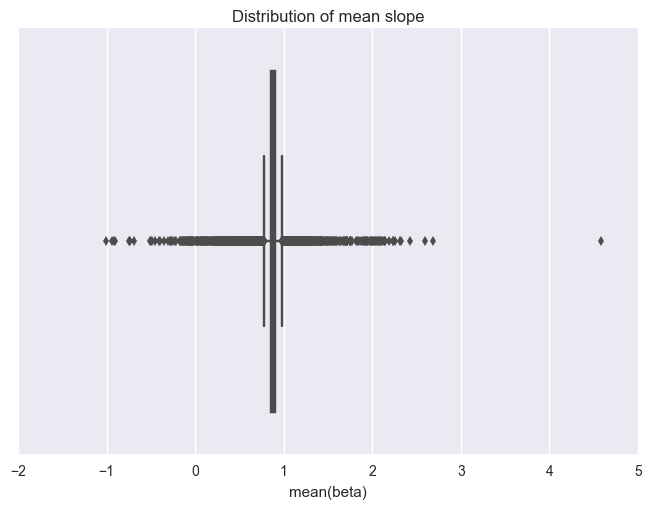

In [10]:
# Plot means distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean slope")
g.set_xlabel("mean(beta)");

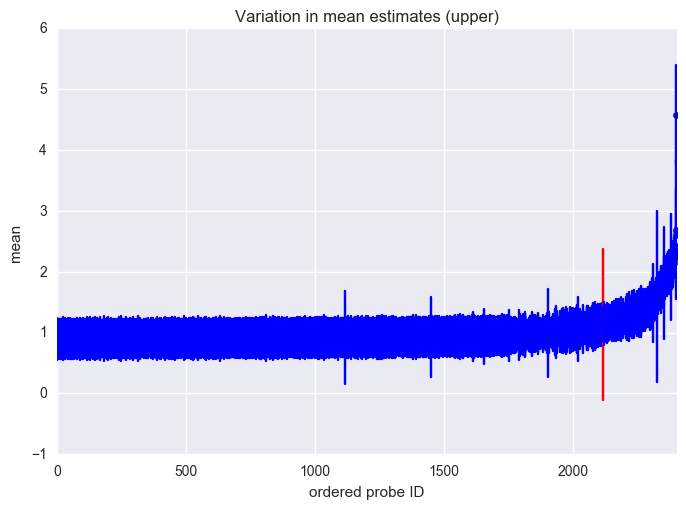

In [11]:
# errors for slope outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.9)

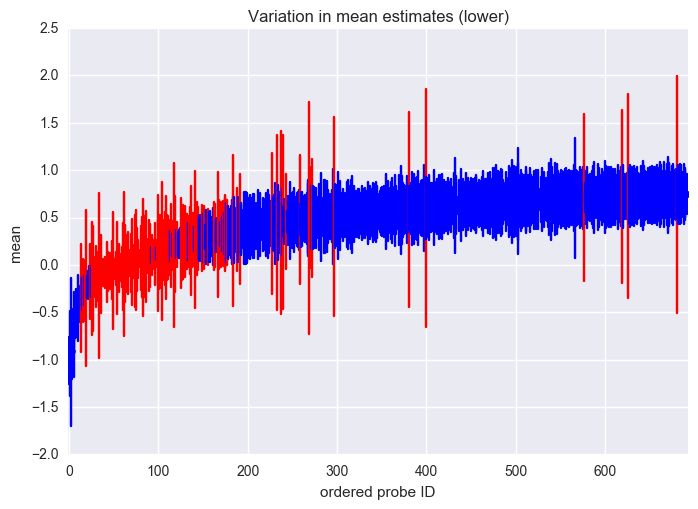

In [12]:
# errors for slope outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.75, upper=False)

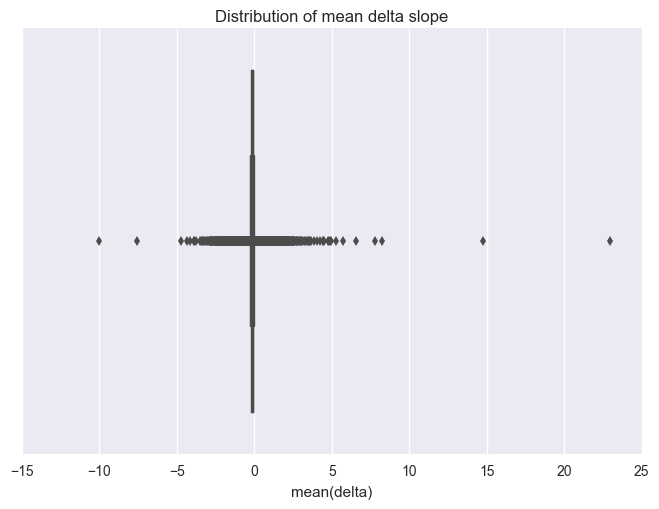

In [13]:
# Plot means distribution
g = sns.boxplot(delta_estimates)
g.set_title("Distribution of mean delta slope")
g.set_xlabel("mean(delta)");

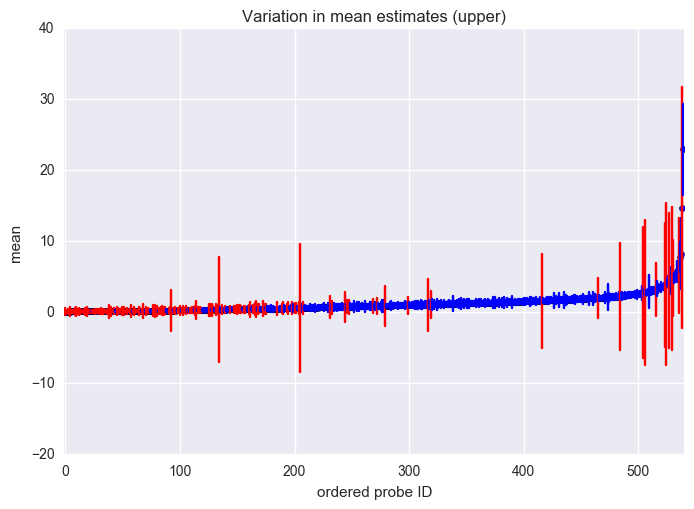

In [14]:
# errors for slope outliers
tools.plot_threshold_errors(delta_estimates, delta_se, 0.1)

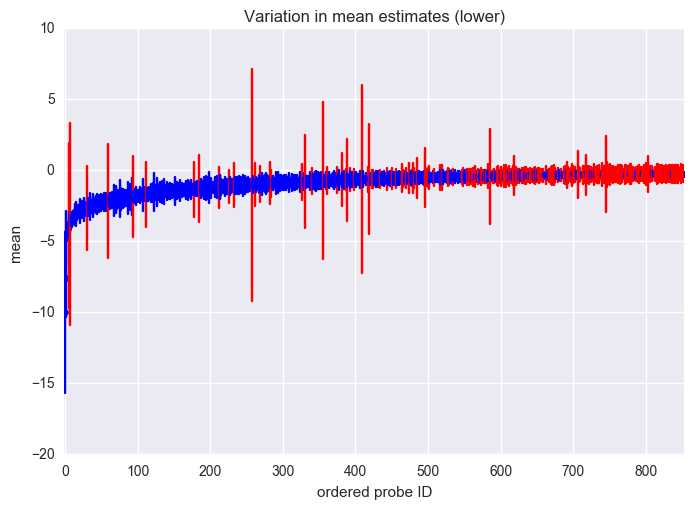

In [15]:
# errors for slope outliers
tools.plot_threshold_errors(delta_estimates, delta_se, -0.25, upper=False)

# Recovering predictions

In [16]:
# Get output log intensity estimates
y_pred_estimates = pd.Series(prediction_fit['y_pred'].mean(0))
y_pred_se = pd.Series(prediction_fit['y_pred'].std(0))

In [17]:
test_data = test_data.reset_index(drop=True)
test_data['y_pred_mean'] = y_pred_estimates
test_data['y_pred_se'] = y_pred_se
test_data.sort_values('locus_tag', inplace=True)

In [18]:
test_data.head()

,dh10b_match,input,locus_tag,log_input,log_output,match,output,probe,replicate,sakai_match,treatment,probe_index,locus_index,y_pred_mean,y_pred_se
541,1.0,6026.244000,ECDH10B_RS00010,8.703879,8.527294,lcl|NC_010473.1_cds_WP_001264707.1_2,5050.760667,A_07_P010704,3,0,0,8059,8052,8.285949,0.388088
2945,1.0,3790.117000,ECDH10B_RS00015,8.240152,7.967212,lcl|NC_010473.1_cds_WP_000241662.1_3,2884.804000,A_07_P010710,3,1,0,5828,8046,7.907883,0.402078
4562,1.0,1117.641667,ECDH10B_RS00015,7.018976,6.759837,lcl|NC_010473.1_cds_WP_000241662.1_3,862.501833,A_07_P010710,3,1,1,5828,8046,6.697824,0.412354
2085,1.0,3162.275667,ECDH10B_RS00020,8.059047,7.769151,lcl|NC_010473.1_cds_WP_000781074.1_4,2366.462333,A_07_P010711,3,0,1,7741,7424,7.755444,0.365844
3052,1.0,10078.852667,ECDH10B_RS00020,9.218195,9.021965,lcl|NC_010473.1_cds_WP_000781074.1_4,8283.041000,A_07_P010711,3,0,0,7741,7424,8.906038,0.373674


(3500, 7978)

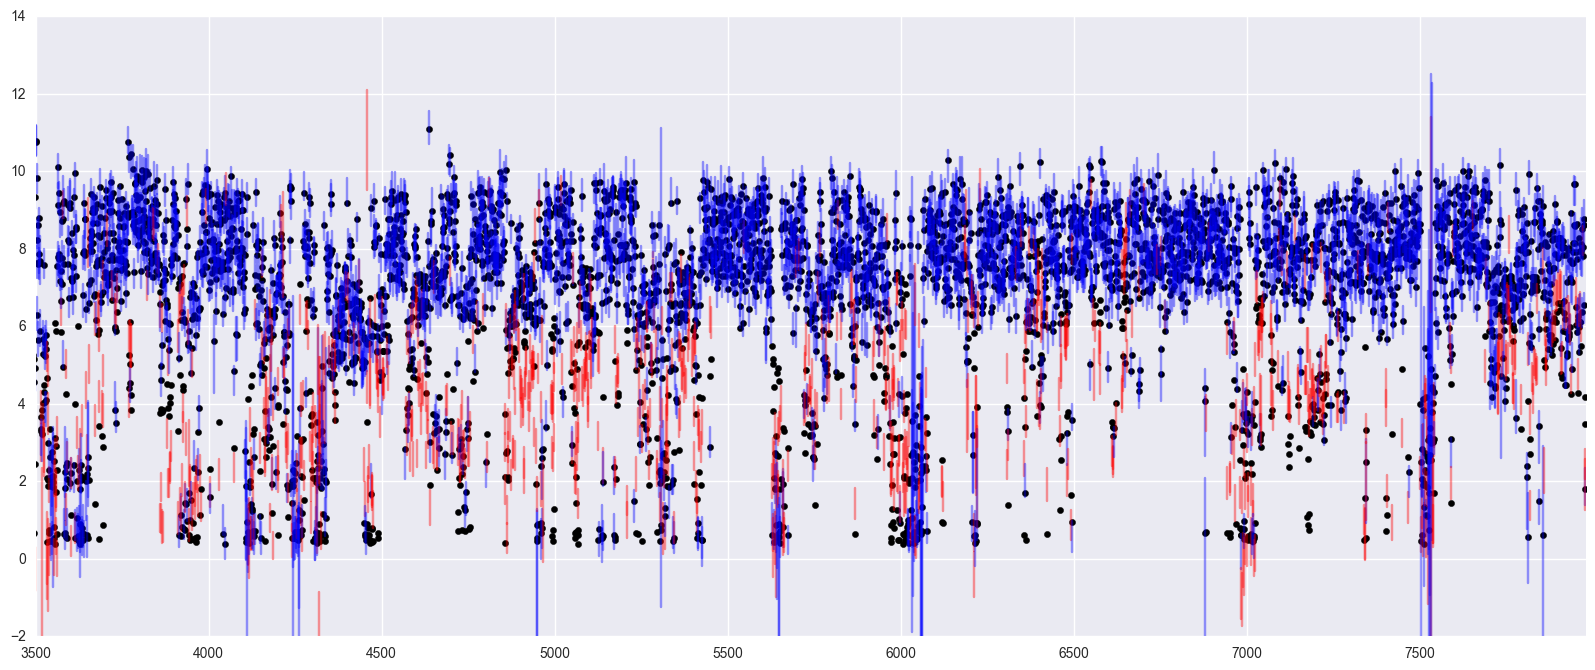

In [31]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
plt.scatter(range(len(test_data)), test_data['log_output'], alpha=1, color='k')
pos, neg = 0, 0
for idx, pmn, pse, mlo in zip(range(len(test_data)),
                              test_data['y_pred_mean'],
                              test_data['y_pred_se'],
                              test_data['log_output']):
    if pse > abs(pmn-mlo):
        pos += 1
        color = 'b-'
    else:
        neg += 1
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    plt.plot([idx, idx], [pmn - pse, pmn + pse], color, alpha=0.4)
plt.ylim(-2, 14)
plt.xlim(3500, len(test_data))
#plt.xlim(800, 1000)

In [32]:
pos, neg, pos/(pos+neg), neg/(pos+neg)

(6902, 1076, 0.8651291050388569, 0.13487089496114316)

In [20]:
beta_means = pd.DataFrame(beta_estimates)
beta_means.reset_index(inplace=True)
beta_means.columns = ['locus_tag', 'beta']
beta_means.head()

,locus_tag,beta
0,ECs1176,-0.048877
1,ECs2998,0.395547
2,ECs2997,0.646087
3,ECs2996,0.052290
4,ECs2993,1.585110


In [21]:
out = pd.merge(test_data, beta_means, 'inner', ['locus_tag'])

In [22]:
len(test_data), len(out['beta'])

(7978, 7978)

(0, 7978)

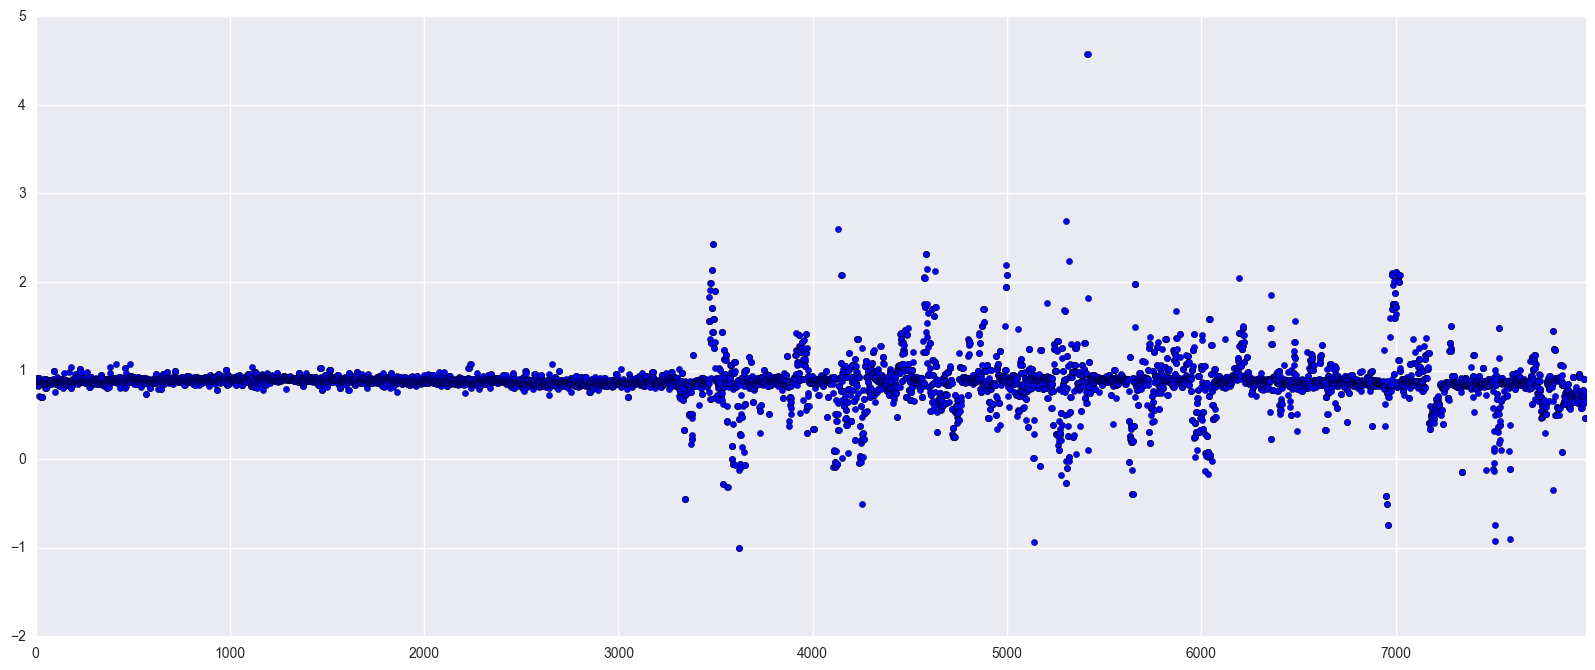

In [29]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
#plt.scatter(range(len(test_data)), test_data['beta'], alpha=1, color='k')
plt.scatter(range(len(test_data)), out['beta'])
for idx, pmn, pse, mlo in zip(range(len(out)),
                              out['y_pred_mean'],
                              out['y_pred_se'],
                              out['log_output']):
    if pse > abs(pmn-mlo):
        color = 'b-'
    else:
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    #plt.plot([idx, out['beta']])
plt.xlim(0, len(out))
#plt.xlim(800, 1000)
#plt.ylim(0.4, 1.2)

In [24]:
gamma_means = pd.DataFrame(gamma_estimates)
gamma_means.reset_index(inplace=True)
gamma_means.columns = ['locus_tag', 'gamma']
gamma_means.head()

,locus_tag,gamma
0,ECs1176,-1.507987
1,ECs2998,-0.477065
2,ECs2997,0.003506
3,ECs2996,-1.440740
4,ECs2993,1.716157


In [25]:
out = pd.merge(out, gamma_means, 'inner', ['locus_tag'])

(0, 7978)

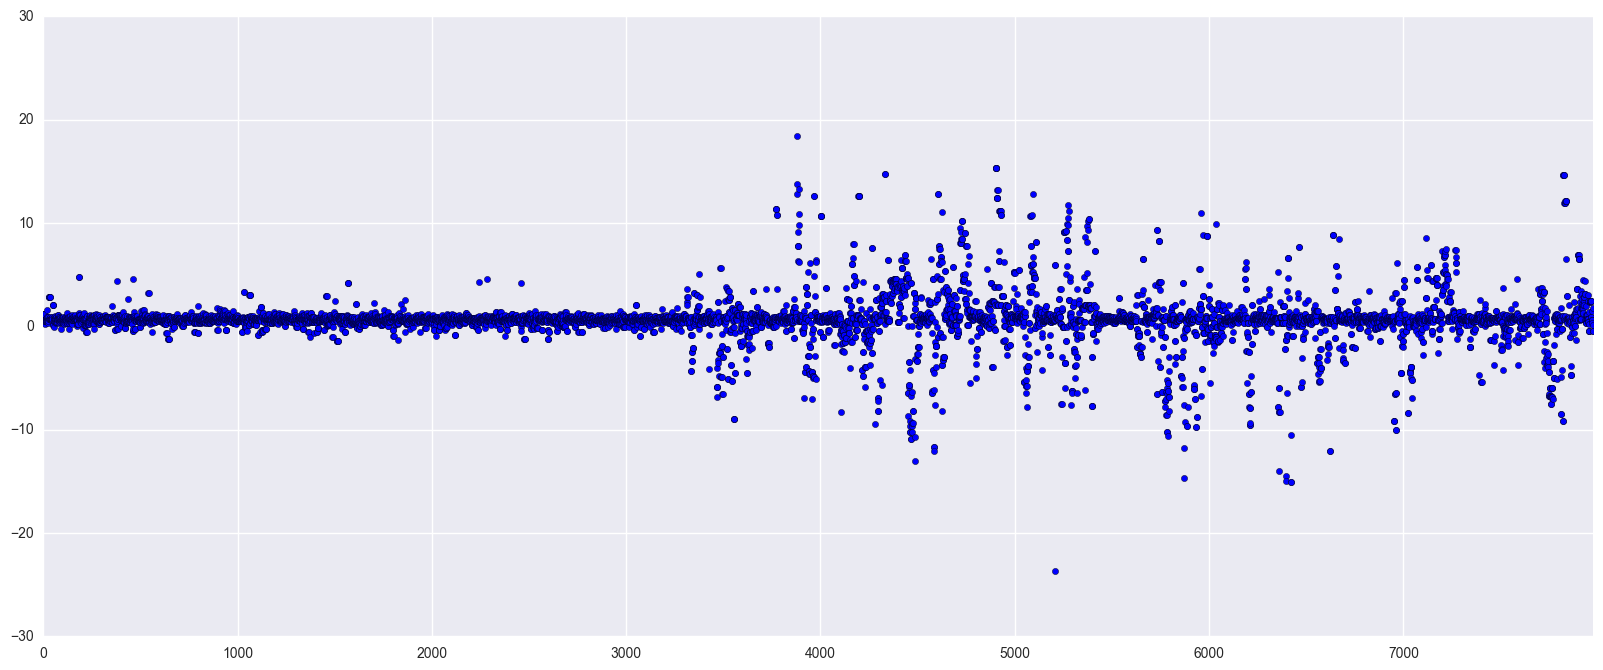

In [28]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
#plt.scatter(range(len(test_data)), test_data['beta'], alpha=1, color='k')
plt.scatter(range(len(test_data)), out['gamma'])
for idx, pmn, pse, mlo in zip(range(len(out)),
                              out['y_pred_mean'],
                              out['y_pred_se'],
                              out['log_output']):
    if pse > abs(pmn-mlo):
        color = 'b-'
    else:
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    #plt.plot([idx, out['beta']])
plt.xlim(0, len(out))
#plt.xlim(800, 1000)
#plt.ylim(0.1, 5)